<a href="https://colab.research.google.com/github/hongan-z/_Mechine_Learning_ML/blob/main/NC4_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11501568/11490434 [==============================] - 0s 0us/step


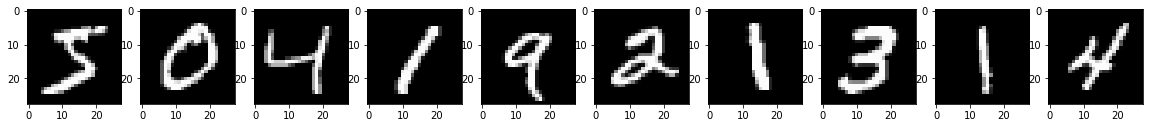

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as rand
from sklearn.model_selection import train_test_split 
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
images = 10;
plt.figure(figsize=(images*2,2))
plt.gray()
for i in range(images):
  plt.subplot(1, images, i+1)
  plt.imshow(x_train[i])
plt.show()
x_train = x_train/255;

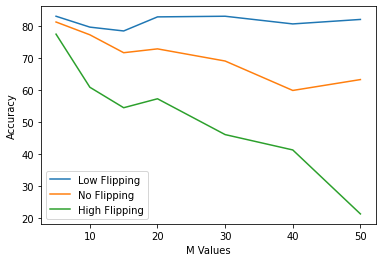

In [11]:
def SSL(M = 1, K = 5, alpha = 100, ratio = 50):
  rand.seed(1)
  #ratio = float(ratio/100)
  #alpha = float(alpha/100)
  nodes = 500;
  X_images = x_train[:nodes]
  X_labels = y_train[:nodes]

  ratio = 0.2; #assuming 1% is labeled
  labeled_amnt = int(np.floor(ratio*nodes)); #amount of nodes we want labeled

  Y = np.zeros((nodes, 10)) #100 by 10 (one hot vector)

  random_index = np.random.choice(nodes, labeled_amnt, replace=False)
  
  for indexes in range(labeled_amnt):
    index = random_index[indexes]; 
    curr_label = X_labels[index]; 
    Y[index][curr_label] = 1; 

  g = 1.25; 

  W_matrix = np.zeros((nodes, nodes))
  distances = np.zeros((nodes, nodes))
  for i in range(nodes):
    for j in range(nodes):
      distances[i][j] = np.linalg.norm(X_images[i] - X_images[j]);
      d1 = distances[i][j]
      W_matrix[i][j] = np.exp(-g*d1**2)

  for i in range(nodes):
    for j in range(nodes):
      if i == j:
        W_matrix[i][j] = 0


  max_iter = 20;
  alpha = 0.8;
  K = 5;

  knn_graph = np.zeros((nodes, nodes))
  for node in range(nodes):
    nodes_closest = np.argsort(distances[node])
    for closest in range(K):
      index = nodes_closest[closest+1]
      knn_graph[node][index] = W_matrix[node][index];
      knn_graph[index][node] = W_matrix[node][index];

  knn_degrees = np.zeros(nodes);
  for i in range(nodes):
    knn_degrees[i] = np.count_nonzero(knn_graph[i]);

  Dmatrix = np.zeros((nodes, nodes))
  for i in range(nodes):
    Dmatrix[i][i] = np.sum(knn_graph[i])

  Dinv = np.linalg.inv(Dmatrix)
  S = Dinv@knn_graph

  #random_index: indexes of the 100 labeled
  #labeled_degrees: vector of the 100 labeled nodes 
  #knn_degrees: vector of ALL degrees
  labeled_degrees = np.zeros(labeled_amnt)
  for index in range(labeled_amnt):
    #random_index: [0 5 10 15 20]
    #random_index[0]: 0
    labeled_index = random_index[index]
    #labeled_degrees[0] = knn_degrees[0] <- 15
    #labeled_degrees[1] = knn_degrees[5] <- 7
    #labeled_degrees[2] = knn_degrees[10] <- 11
    #labeled_degrees[3] = knn_degrees[15] <- 2
    #labeled_degrees[4] = knn_degrees[20] <- 12
    
    #random_index:    [0  5 10 15 20]
    #labeled_degrees: [15 7 11 2  12]

    #lowdeg_index =              [3  1 2  4  0]
    #random_index:               [15 5 10 20 0]
    labeled_degrees[index] = knn_degrees[labeled_index]

  #M = 30
  lowdeg_index = np.argsort(labeled_degrees)[:M];
  highdeg_index = np.argsort(-1*labeled_degrees)[:M];

  lowflip_Y = np.copy(Y)
  for i in range(len(lowdeg_index)):
    labeled_index = random_index[lowdeg_index[i]]
    lowflip_label = np.nonzero(lowflip_Y[random_index[lowdeg_index[i]]])[0][0]
    actual_label = X_labels[labeled_index]

    while lowflip_label == actual_label:
      lowflip_Y[labeled_index][lowflip_label] = 0
      random_label = rand.randint(0, 9)
      lowflip_Y[labeled_index][random_label] = 1
      lowflip_label = random_label

  highflip_Y = np.copy(Y)
  for i in range(len(highdeg_index)):
    labeled_index = random_index[highdeg_index[i]]
    highflip_label = np.nonzero(highflip_Y[random_index[highdeg_index[i]]])[0][0]
    actual_label = X_labels[labeled_index]

    while highflip_label == actual_label:
      highflip_Y[labeled_index][highflip_label] = 0
      random_label = rand.randint(0, 9)
      highflip_Y[labeled_index][random_label] = 1
      highflip_label = random_label

  F = Y;
  F2 = lowflip_Y
  F3 = highflip_Y

  for i in range(max_iter):
    F = alpha * S @ F + (1 - alpha) * Y
    F2 = alpha * S @ F2 + (1 - alpha) * lowflip_Y
    F3 = alpha * S @ F3 + (1 - alpha) * highflip_Y

  Y_final = np.zeros(nodes)
  Y2_final = np.zeros(nodes)
  Y3_final = np.zeros(nodes)
  for i in range(nodes):
    label = np.argmax(F[i])
    Y_final[i] = label
    label = np.argmax(F2[i])
    Y2_final[i] = label
    label = np.argmax(F3[i])
    Y3_final[i] = label

  correct = 0
  for val in range(nodes):
    if X_labels[val] == Y_final[val]:
      correct = correct + 1
  noflip = correct*100/nodes


  correct = 0
  for val in range(nodes):
    if X_labels[val] == Y2_final[val]:
      correct = correct + 1

  lowflip = correct*100/nodes


  correct = 0
  for val in range(nodes):
    if X_labels[val] == Y3_final[val]:
      correct = correct + 1

  highflip = correct*100/nodes

  return noflip, lowflip, highflip

Mvalues = [5, 10, 15, 20, 30, 40, 50]

NoFlip_Accuracy = np.zeros(len(Mvalues))
LowFlip_Accuracy = np.zeros(len(Mvalues))
HighFlip_Accuracy = np.zeros(len(Mvalues))
for M in range(len(Mvalues)):
  [noflip, lowest, highest] = SSL(M = Mvalues[M])
  NoFlip_Accuracy[M] = noflip
  LowFlip_Accuracy[M] = lowest
  HighFlip_Accuracy[M] = highest
plt.plot(Mvalues, NoFlip_Accuracy)
plt.plot(Mvalues, LowFlip_Accuracy)
plt.plot(Mvalues, HighFlip_Accuracy)
plt.legend({'No Flipping','Low Flipping','High Flipping'})
plt.xlabel("M Values")
plt.ylabel("Accuracy")
plt.show() 

